In [3]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve, validation_curve, train_test_split,  RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae, make_scorer
from sklearn.inspection import permutation_importance

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.pipeline import Pipeline as IMBPipeline


import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Sporcare il dataset coi missing values<br><br>
Provare catboost e confrontare prestazioni con onehotencoder<br><br>
Aumentare dimensionality reduction e confrontare i risultati<br><br>
Calcolo del punteggio di ogni feature per capire se il pretest è effettivamente incisivo<br><br>


In [4]:
test_df = pd.read_csv('test_scores.csv')
test_df

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...
2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,T8LSK,Female,Does not qualify,39.0,55.0
2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,VNP26,Female,Qualifies for reduced/free lunch,38.0,46.0
2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,YDR1Z,Female,Qualifies for reduced/free lunch,45.0,51.0
2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,YUEIH,Male,Qualifies for reduced/free lunch,46.0,53.0


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


In [6]:
#test_df['pretest'] = test_df['pretest'].apply(lambda val: 1 if val >= 60 else 0)

In [7]:
test_df.isnull().sum()

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

In [8]:
X = test_df.drop(['posttest'], axis=1)
y = test_df['posttest']

Custom transformers which is not currently used

In [9]:
'''class GradeTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = (X >= 60).astype(int)
        return X

class MethodTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, column):
        X = X.map({'Standard': 0, 'Experimental': 1})
        return X

class LunchTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, column):
        X[column] = X[column].map({'Does not qualify': 0, 'Qualifies for reduced/free lunch': 1})
        return X'''

"class GradeTransformer(BaseEstimator, TransformerMixin):\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        X = (X >= 60).astype(int)\n        return X\n\nclass MethodTransformer(BaseEstimator, TransformerMixin):\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X, column):\n        X = X.map({'Standard': 0, 'Experimental': 1})\n        return X\n\nclass LunchTransformer(BaseEstimator, TransformerMixin):\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X, column):\n        X[column] = X[column].map({'Does not qualify': 0, 'Qualifies for reduced/free lunch': 1})\n        return X"

Pipelines not currently used

In [10]:
'''num_pipeline = Pipeline([ #n_student, 
    ('scaler', StandardScaler())
])
grade_pipeline = Pipeline([ #should be the pipeline for both pretest and (target) posttest
    ('custom', GradeTransformer())
])
school_pipeline = Pipeline([ #to understand how to handle other related columns, for now we drop them
    ('label', LabelEncoder())
])
dual_pipeline = Pipeline([ #teaching, lunch, gender, method
    ('label', LabelEncoder()) #to change all label if we will deal with a model that care about ordinality (as linear regression)
]) 
label_pipeline = Pipeline([
    ('label', LabelEncoder()), #convert all strings in ordered integers
    ('std', StandardScaler()) #shrinks all integers in a range from 
])'''

final_transformation = ColumnTransformer(transformers=[
    ('school', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school'] ), #we could also think to join school and classroom
    ('school_type', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school_type']),
    ('school_setting', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school_setting']),
    ('teaching_method', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['teaching_method']),
    ('classroom', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['classroom']),
    ('n_student', StandardScaler(), ['n_student']),
    ('gender', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['gender']),
    ('lunch', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['lunch']),
    ('pretest', StandardScaler(), ['pretest'])
    # ('posttest', grade_pipeline, ['posttest']), target column
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0
    )

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) # , stratify=y
X_train #, y_train

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest
1573,UKPGS,Suburban,Public,PGH,Experimental,23.0,W2GFZ,Female,Does not qualify,72.0
1898,VVTVA,Urban,Public,TB5,Standard,25.0,59212,Male,Qualifies for reduced/free lunch,40.0
1435,UAGPU,Suburban,Public,NWZ,Standard,21.0,EHWEI,Male,Does not qualify,58.0
1288,QOQTS,Urban,Public,RK7,Standard,22.0,1MUNN,Male,Does not qualify,55.0
1963,ZMNYA,Suburban,Public,1UU,Experimental,24.0,S5K17,Female,Does not qualify,67.0
...,...,...,...,...,...,...,...,...,...,...
1638,UUUQX,Suburban,Non-public,H7S,Experimental,16.0,9J2Z8,Female,Does not qualify,71.0
1095,KZKKE,Rural,Public,QTU,Standard,23.0,Y2WEZ,Female,Qualifies for reduced/free lunch,36.0
1130,LAYPA,Rural,Public,J8J,Standard,19.0,POKHM,Female,Does not qualify,60.0
1294,QOQTS,Urban,Public,RK7,Standard,22.0,A8OCT,Male,Does not qualify,49.0


SMOTE non si può usare perché Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1

In [12]:
X_train = final_transformation.fit_transform(X_train)
X_test = final_transformation.transform(X_test)
model_pipeline = IMBPipeline([
    # ('sampler', ADASYN(random_state=42)),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LinearRegression())
])

In [13]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('dim_reduction', PCA(n_components=0.8)),
                ('classifier', LinearRegression())])

In [14]:
score_r2 = r2_score(y_test, model_pipeline.predict(X_test))
score_mse = mse(y_test, model_pipeline.predict(X_test))
score_mae = mae(y_test, model_pipeline.predict(X_test))
print(f"Mean Squared Error (MSE): {score_mse}")
print(f"R2 score {score_r2}")
print(f"Mean Absolute Error (MAE): {score_mae}")

Mean Squared Error (MSE): 10.116724121195682
R2 score 0.9498911848700531
Mean Absolute Error (MAE): 2.513753101031516


In [15]:
# sampler_configs = [
#     {
#        'sampler':[None],# The element is bypassed
#    },
#    {
#        'sampler':[ADASYN(n_jobs=-1)],
#        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
#    },
#    {
#        'sampler':[RandomOverSampler()],
#        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
#    }
#]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.3, 0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'accuracy')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsRegressor()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
    # {
    #     'classifier' : [AdalineGD()],
    #     'classifier__epochs' : [0.5, 0.1, 0.05, 0.01, 0.003, 0.001, 0.0005],
    #     'classifier__eta' : [10, 50, 100]
    # }
]

In [16]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(dim_reduction_configs,classifier_configs)] #sampler_configs,

In [17]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 16'

In [18]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring = 'r2',
    error_score='raise'
)

In [19]:
scores = cross_validate(rs, X_train, y_train, scoring='r2', cv = 5, return_estimator=True, verbose=3) #26 minutes (3.0, 2.9, 2.1, 3.4, )

[CV] END ......................................., score=0.942 total time= 2.6min
[CV] END ......................................., score=0.939 total time= 3.7min
[CV] END ......................................., score=0.956 total time= 3.4min
[CV] END ......................................., score=0.945 total time= 3.6min
[CV] END ......................................., score=0.951 total time= 2.3min


In [20]:
for index, estimator in enumerate(scores['estimator']):
    #print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*25)

LinearDiscriminantAnalysis()
KNeighborsRegressor() {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9418003544868103
-------------------------
LinearDiscriminantAnalysis()
KNeighborsRegressor() {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9389904214374329
-------------------------
LinearDiscriminantAnalysis()
KNeighborsRegressor() {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9558184760569396
-------------------------
LinearDiscriminantAnalysis()
KNeighborsRegressor() {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.9450852683394387
-------------------------
LinearDiscriminantAn

In [21]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    mse_train = mse(y_train, pred_train)
    mse_test = mse(y_test, pred_test)
    mae_train = mae(y_train, pred_train)
    mae_test = mae(y_test, pred_test)
    print(f'R2 on training set:{r2_train}, R2 on test set:{r2_test}')
    print(f'MSE on training set:{mse_train}, MSE on test set:{mse_test}')
    print(f'MAE on training set:{mae_train}, MAE on test set:{mae_test}')
    print("-------------------------------------------------------------")


R2 on training set:0.9658114652238557, R2 on test set:0.9431427316283216
MSE on training set:6.539984362783424, MSE on test set:11.4792037470726
MAE on training set:2.048162627052385, MAE on test set:2.6494145199063235
-------------------------------------------------------------
R2 on training set:0.9658114652238557, R2 on test set:0.9431427316283216
MSE on training set:6.539984362783424, MSE on test set:11.4792037470726
MAE on training set:2.048162627052385, MAE on test set:2.6494145199063235
-------------------------------------------------------------
R2 on training set:0.9658114652238557, R2 on test set:0.9431427316283216
MSE on training set:6.539984362783424, MSE on test set:11.4792037470726
MAE on training set:2.048162627052385, MAE on test set:2.6494145199063235
-------------------------------------------------------------
R2 on training set:0.9658114652238557, R2 on test set:0.9431427316283216
MSE on training set:6.539984362783424, MSE on test set:11.4792037470726
MAE on train

In [27]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', LDA()), 
    ('classifier',KNeighborsRegressor()) # boh ora sembra essere meglio la randomforest
])

In [28]:
params = {
    'classifier__n_neighbors': [3,5,7,9]
    #'classifier__C': loguniform(0.001, 100),
    # 'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
}

In [29]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='r2',
    error_score = 'raise'
)

In [30]:
X = test_df.drop(['posttest', 'student_id'], axis=1)
y = test_df['posttest']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train #, y_train

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest
480,FBUMG,Rural,Non-public,5LQ,Experimental,18.0,Male,Does not qualify,67.0
1660,UUUQX,Suburban,Non-public,P8I,Standard,20.0,Female,Does not qualify,68.0
719,GOOBU,Urban,Public,CXC,Standard,24.0,Female,Qualifies for reduced/free lunch,33.0
836,GOOBU,Urban,Public,W8A,Experimental,26.0,Female,Qualifies for reduced/free lunch,41.0
1013,KZKKE,Rural,Public,3D0,Standard,22.0,Female,Qualifies for reduced/free lunch,29.0
...,...,...,...,...,...,...,...,...,...
1638,UUUQX,Suburban,Non-public,H7S,Experimental,16.0,Female,Does not qualify,71.0
1095,KZKKE,Rural,Public,QTU,Standard,23.0,Female,Qualifies for reduced/free lunch,36.0
1130,LAYPA,Rural,Public,J8J,Standard,19.0,Female,Does not qualify,60.0
1294,QOQTS,Urban,Public,RK7,Standard,22.0,Male,Does not qualify,49.0


In [31]:
rs_best.fit(X_train, y_train) #20.5 min

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('school',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['school']),
                                                                              ('school_type',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['school_type']...
                                                                                             handle_unknown='ignore'),
                                                                               ['gender']),
                                                                              ('lunch',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['lunch']),
                                                                              ('pretest',
                                                                               StandardScaler(),
                                                                               ['pretest'])],
                                                                verbose_feature_names_out=False)),
                                             ('dim_reduction',
                                              LinearDiscriminantAnalysis()),
                                             ('classifier',
                                              KNeighborsRegressor())]),
                   n_iter=20,
                   param_distributions={'classifier__n_neighbors': [3, 5, 7,
                                                                    9]},
                   scoring='r2')

In [32]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('school',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['school']),
                                                 ('school_type',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['school_type']),
                                                 ('school_setting',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['school_setting']),
                                                 ('teaching_method',
                                                  OneHotE...
                                                 ('n_student', StandardScaler(),
                                                  ['n_student']),
                                                 ('gender',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender']),
                                                 ('lunch',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['lunch']),
                                                 ('pretest', StandardScaler(),
                                                  ['pretest'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier', KNeighborsRegressor(n_neighbors=7))])

In [33]:
y_pred = rs_best.best_estimator_.predict(X_test)

In [34]:
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"MSE Score: {mse(y_test, y_pred)}")
print(f"MAE Score: {mae(y_test, y_pred)}")

R2 Score: 0.9455694406741018
MSE Score: 10.948286574582998
MAE Score: 2.5463365674138507


In [35]:
cls = rs_best.best_estimator_

In [36]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'r2',
                                                       shuffle = False) #15 secs

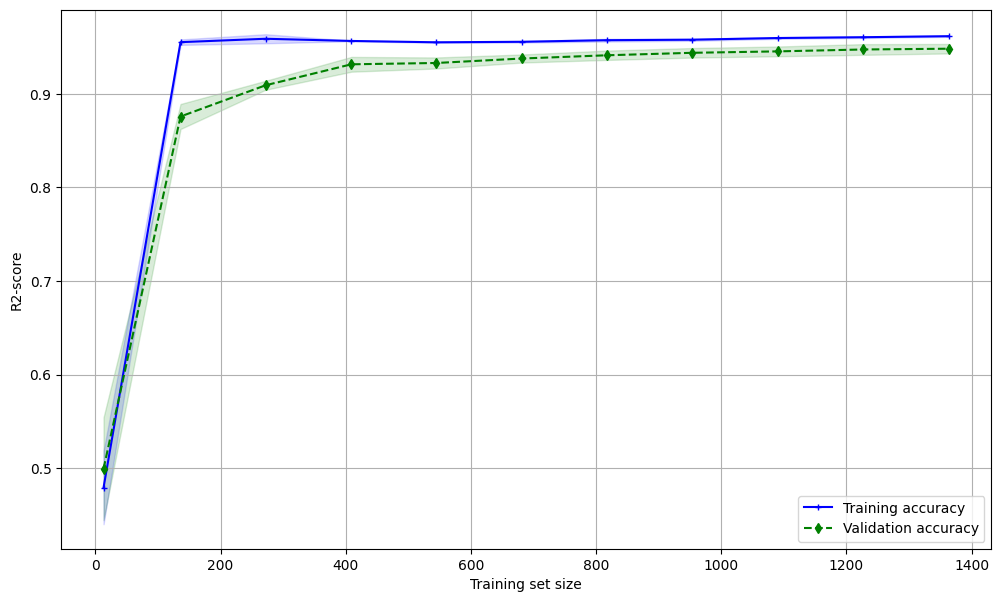

In [37]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('R2-score')
ax.legend(loc='lower right')
# ax.set_ylim([0.60, 1.03])

In [40]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_C, 
        param_name='classifier__n_neighbors',
        cv=5, 
        n_jobs=-1, 
        scoring='r2'
)

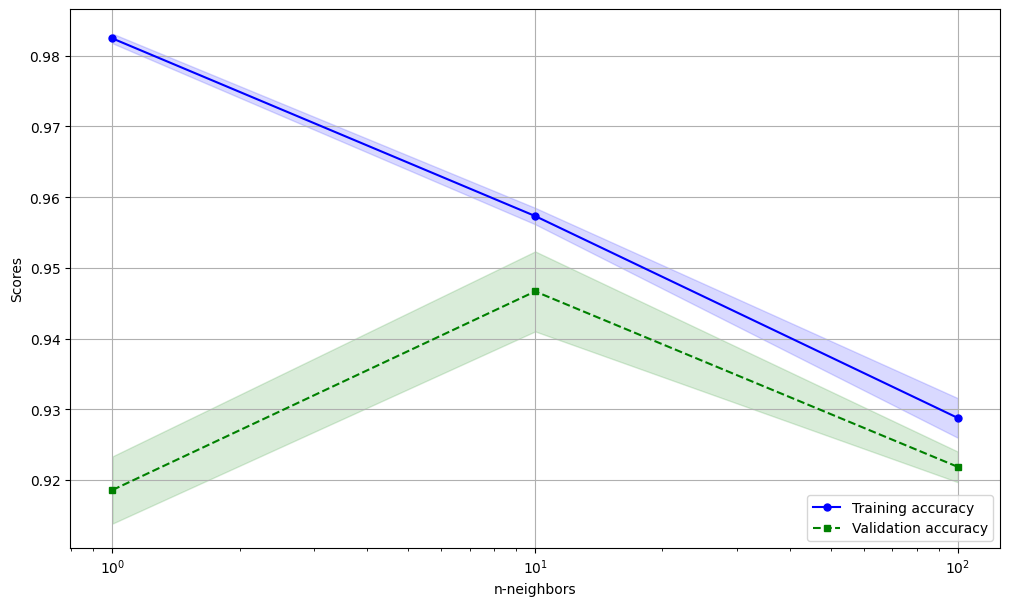

In [41]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('n-neighbors')
ax.set_ylabel('Scores')
ax.legend(loc='lower right')
#ax.set_ylim([0, 1.2])
ax.set_xscale('log')


Negative R²:
R² can be negative when the model performs worse than a simple baseline model that always predicts the mean of the target variable.
A negative R² occurs when the residual sum of squares (SSE) is larger than the total sum of squares (SST), meaning that the model's predictions are worse than simply predicting the average value of the target for all data points.

In [42]:
print(f'train mean: {train_mean}')
print(f'train std: {train_std}')
print(f'test mean: {test_mean}' )
print(f'test std: {test_std}')

train mean: [       nan        nan        nan 0.98244738 0.9573297  0.92877257]
train std: [       nan        nan        nan 0.00068069 0.00116415 0.00280217]
test mean: [       nan        nan        nan 0.91858447 0.94667116 0.92185401]
test std: [       nan        nan        nan 0.00475287 0.0056578  0.0021628 ]


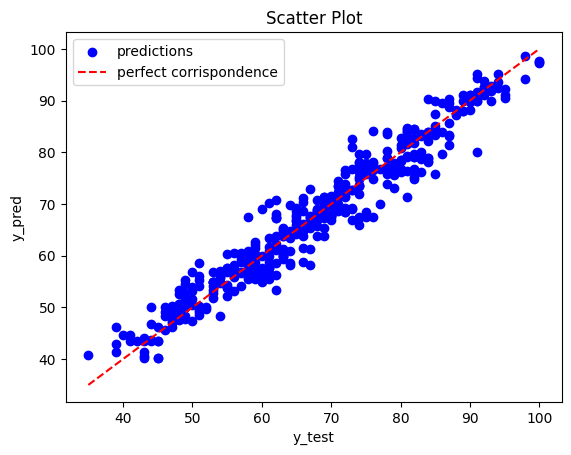

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Supponendo che y_test e y_pred siano già definiti e abbiano la stessa lunghezza

plt.scatter(y_test, y_pred, c='blue', label='predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect corrispondence')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatter Plot')
plt.legend()
plt.show()

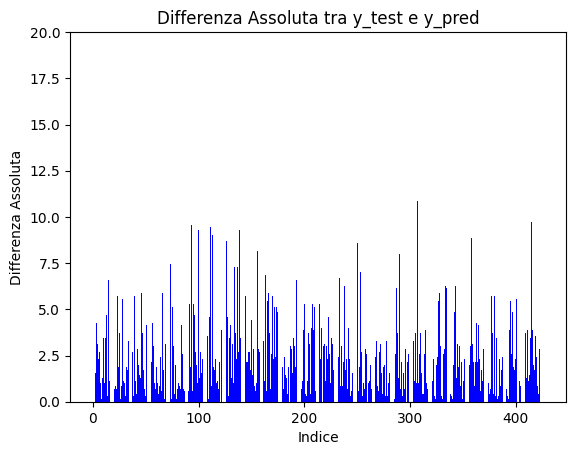

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Supponendo che y_test e y_pred siano già definiti e abbiano la stessa lunghezza

# Calcola la differenza assoluta
diff = np.abs(y_test - y_pred)
# Crea un grafico a barre
plt.bar(range(len(y_test)), diff, color='blue')
plt.xlabel('Indice')
plt.ylabel('Differenza Assoluta')
plt.title('Differenza Assoluta tra y_test e y_pred')
plt.ylim(0,20)

plt.show()

In [45]:
np.average(diff)

2.5463365674138507

yet to do:
- Feature evaluation and feature selection
- Check the effectiveness of others model and combinations


FEATURE SELECTION

In [48]:
# Calcola l'importanza delle feature 
knn_model = best_model_pipeline.named_steps['classifier']
result = permutation_importance(knn_model, X_train, y_train, n_repeats=30, random_state=0) 
# Visualizza l'importanza delle feature 
importance_df = pd.DataFrame(result.importances_mean, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False) 
# Visualizza i risultati 
importance_df.plot(kind='bar') 
plt.title('Feature Importance') 
plt.xlabel('Feature') 
plt.ylabel('Importance') 
plt.show()

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.